Сейчас я буду прогонять получившиеся признаки через все классификаторы и смотреть, что получится и какой классификатор справляется лучше

In [61]:
import re
import nltk
import string
import itertools
import numpy as np
import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline 
import graphviz
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix

In [174]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from gensim.models.keyedvectors import FastTextKeyedVectors
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score


In [270]:
df_features = pd.read_csv('gk4z_features.csv')
df_features.tail()

,id,text,likes,label,len_char,punct,punct_count,punct%,tokens,tokens_count,tokens%,smiles,smiles_count,smiles%,numbers_count,numbers%,latin_count,latin%
56195,37,ходить кругами сабатон что за мем,23,post,33,NaN,0,0.0,"['ходить', 'кругами', 'сабатон', 'что', 'за', ...",6,0.181818,NaN,0,0.0,0,0.0,0,0.0
56196,33,отель арарат снять номер,63,post,24,NaN,0,0.0,"['отель', 'арарат', 'снять', 'номер']",4,0.166667,NaN,0,0.0,0,0.0,0,0.0
56197,31,рэй джаст арена охранники,57,post,25,NaN,0,0.0,"['рэй', 'джаст', 'арена', 'охранники']",4,0.160000,NaN,0,0.0,0,0.0,0,0.0
56198,20,жирный из аскинг александрия куда делся,90,post,39,NaN,0,0.0,"['жирный', 'из', 'аскинг', 'александрия', 'куд...",6,0.153846,NaN,0,0.0,0,0.0,0,0.0
56199,1,что такое гиг,79,post,13,NaN,0,0.0,"['что', 'такое', 'гиг']",3,0.230769,NaN,0,0.0,0,0.0,0,0.0


Посмотрим, сколько у нас данных какого класса

In [8]:
df_features.label.value_counts()

comment               37762
post                  13813
comment_to_comment     4625
Name: label, dtype: int64

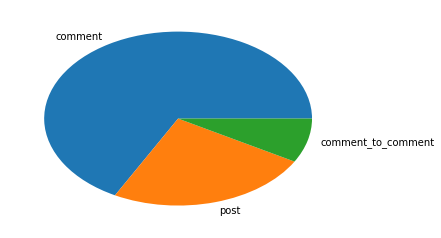

In [14]:
plt.pie(df_features.label.value_counts(), labels = df_features.label.value_counts().index)

plt.show()

Данные достаточно несбалансированные, но посмотрим, как справятся классификаторы.

Для начала вытащим столбцы с признаками

In [15]:
df_features.columns

Index(['id', 'text', 'likes', 'label', 'len_char', 'punct', 'punct_count',
       'punct%', 'tokens', 'tokens_count', 'tokens%', 'smiles', 'smiles_count',
       'smiles%', 'numbers_count', 'numbers%', 'latin_count', 'latin%'],
      dtype='object')

In [5]:
feature_names = ['likes', 'len_char', 'punct_count',
       'punct%', 'tokens_count', 'tokens%', 'smiles_count',
       'smiles%', 'numbers_count', 'numbers%', 'latin_count', 'latin%']

In [63]:
# вытаскиваю значения из нужных столбцов в виде аррея и складываю их в переменную а
a = df_features.filter(items = feature_names)
a = a.values


In [64]:
X_train, X_test, y_train, y_test = train_test_split(a, df_features['label'])

##### Логистическая регрессия

In [21]:
lr = LogisticRegression()
clf = lr.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

                    precision    recall  f1-score   support

           comment       0.87      0.98      0.92      9472
comment_to_comment       0.31      0.03      0.05      1178
              post       0.95      0.93      0.94      3400

       avg / total       0.85      0.89      0.85     14050



Я ожидала, что комменты к комментам распознаются легко, так как большинство из них начинаются с чего-нибудь типа [id17823823|Анастасия], то есть обязательно присутствуют минимум два знака латиницы, много цифр и минимум 3 знака препинания. Но, видимо, классификатор не распознал эти признаки как важные. 

##### SGDClassifier

In [32]:
sgd = SGDClassifier()
sgd_m = sgd.fit(X_train, y_train)
print(classification_report(y_test, sgd_m.predict(X_test)))

                    precision    recall  f1-score   support

           comment       0.89      0.95      0.92      9472
comment_to_comment       0.36      0.17      0.23      1178
              post       0.95      0.94      0.94      3400

       avg / total       0.86      0.88      0.87     14050



Результат такой же

##### DecisionTree

In [67]:
tree_tree = DecisionTreeClassifier(criterion='entropy')
tree_m = tree_tree.fit(X_train, y_train)
print(classification_report(y_test, tree_m.predict(X_test)))

                    precision    recall  f1-score   support

           comment       0.90      0.90      0.90      9408
comment_to_comment       0.33      0.32      0.32      1155
              post       0.94      0.95      0.95      3487

       avg / total       0.86      0.86      0.86     14050



И у решающих деревьев то же самое, только комменты к комментам чуть лучше определились. Посмотрим, какие признаки DecisionTree классификатор посчитал важными.

In [72]:
tree_m.feature_importances_

array([0.57958513, 0.03816314, 0.01403685, 0.04165209, 0.0177482 ,
       0.05659558, 0.00277904, 0.0102218 , 0.10926604, 0.02433453,
       0.07744133, 0.02817627])

In [ ]:
feature_names = ['likes', 'len_char', 'punct_count',
       'punct%', 'tokens_count', 'tokens%', 'smiles_count',
       'smiles%', 'numbers_count', 'numbers%', 'latin_count', 'latin%']

In [81]:
df_tree_features = pd.DataFrame(index=feature_names, data=tree_m.feature_importances_.tolist())
df_tree_features.sort_values(by = [0], ascending=False, inplace = True)
df_tree_features

,0
likes,0.579585
numbers_count,0.109266
latin_count,0.077441
tokens%,0.056596
punct%,0.041652
len_char,0.038163
latin%,0.028176
numbers%,0.024335
tokens_count,0.017748
punct_count,0.014037


Самыми важными признаками классификатор посчитал лайки, количество цифр и количество латинских символов.

Сейчас я хочу визуализировать дерево решений. Я сильно ограничу количество уровней в дереве, чтобы картинка уместилась на экране. Иначе она получается гигантская

In [30]:
tree_tree_short = DecisionTreeClassifier( max_depth = 3)
tree_m = tree_tree_short.fit(X_train, y_train)
print(classification_report(y_test, tree_m.predict(X_test)))

                    precision    recall  f1-score   support

           comment       0.87      0.99      0.92      9468
comment_to_comment       0.00      0.00      0.00      1161
              post       0.95      0.91      0.93      3421

       avg / total       0.82      0.89      0.85     14050



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Устанавливаю graphviz. Как это сделать, я прочла здесь

https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft

In [53]:
#!pip install graphviz --upgrade


You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


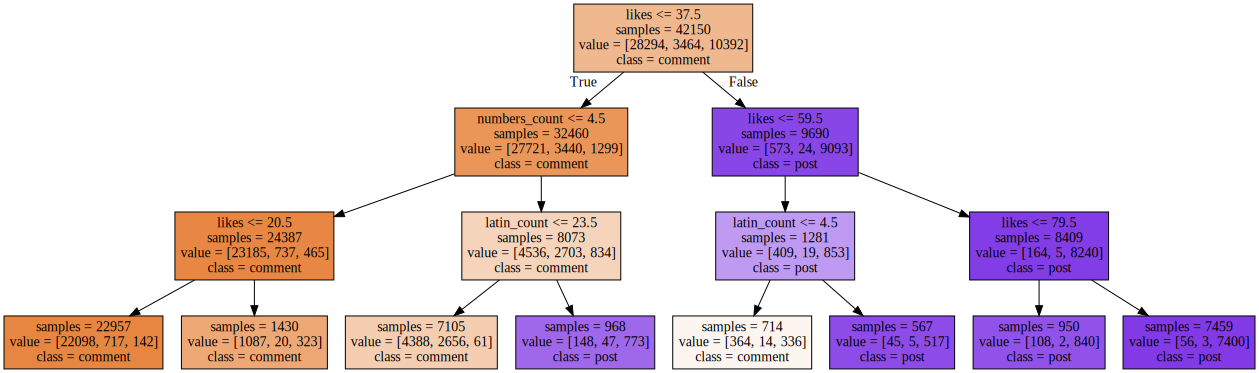

In [31]:
export_graphviz(tree_m, out_file="tree.dot", class_names=['comment', 'comment_to_comment', 'post'],
                feature_names=feature_names, impurity=False, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Итак, самые лучшие результаты дает дерево решений (без ограничения max_depth). Я хочу улучшить распознавание комментов второго уровня. Для этого попробую уменьшить количество параметров и подобрать наиболее подходящие

##### Самые полезные признаки

In [91]:
combinations = list(itertools.combinations(feature_names, 8))

In [83]:
for comb in combinations:
    b = df_features.filter(items = comb).values
    X_train, X_test, y_train, y_test = train_test_split(b, df_features['label'])
    tree_try = DecisionTreeClassifier(criterion='entropy')
    tree_try_m = tree_try.fit(X_train, y_train)
    if precision_recall_fscore_support(y_test, tree_try_m.predict(X_test), average='weighted')[2] > 0.87:
        print(comb, precision_recall_fscore_support(y_test, tree_try_m.predict(X_test), average='weighted'))

('likes', 'numbers_count', 'latin%') (0.8673336247111654, 0.8827046263345196, 0.8730871801027159, None)


In [84]:
b = df_features.filter(items = ['likes', 'numbers_count', 'latin%']).values
X_train, X_test, y_train, y_test = train_test_split(b, df_features['label'])
tree_tree = DecisionTreeClassifier(criterion='entropy')
tree_m = tree_tree.fit(X_train, y_train)
print(classification_report(y_test, tree_m.predict(X_test)))

                    precision    recall  f1-score   support

           comment       0.89      0.94      0.92      9426
comment_to_comment       0.40      0.24      0.30      1156
              post       0.95      0.94      0.94      3468

       avg / total       0.87      0.88      0.87     14050



В результате простого перебора самыми важными признаками оказались те же самые лайки, количество цифр и латиница, только латиница вошла в виде процентного соотношения с общим количеством элементов в тексте.

Я перебрала разные комбинации признаков (и разное их количество) на разных классификаторах, RandomForest попробовала тоже, но как-то сильно результаты улучшить не удалось. 

##### RandomForest

In [86]:
X_train, X_test, y_train, y_test = train_test_split(a, df_features['label'])
forest = RandomForestClassifier(criterion='entropy')
my_forest = forest.fit(X_train, y_train)
print(classification_report(y_test, my_forest.predict(X_test)))

                    precision    recall  f1-score   support

           comment       0.90      0.95      0.92      9445
comment_to_comment       0.41      0.23      0.30      1151
              post       0.97      0.95      0.96      3454

       avg / total       0.87      0.89      0.88     14050



Теперь я попробую нормализовать признаки и посмотрю, улучшаться ли результаты.

##### 1. Normalize

In [100]:
normalized_a = normalize(a)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(normalized_a, df_features['label'])
forest = RandomForestClassifier(criterion='entropy')
my_forest = forest.fit(X_train_n, y_train_n)
print(classification_report(y_test_n, my_forest.predict(X_test_n)))

                    precision    recall  f1-score   support

           comment       0.89      0.95      0.92      9505
comment_to_comment       0.38      0.19      0.26      1188
              post       0.96      0.94      0.95      3357

       avg / total       0.86      0.88      0.87     14050



In [101]:
df_forest_features = pd.DataFrame(index=feature_names, data=my_forest.feature_importances_.tolist())
df_forest_features.sort_values(by = [0], ascending=False, inplace = True)
df_forest_features

,0
tokens%,0.211995
likes,0.181461
len_char,0.174495
tokens_count,0.102619
latin%,0.061485
punct%,0.059317
numbers_count,0.056438
numbers%,0.048009
punct_count,0.045353
latin_count,0.038377


Любопытно, что в РандомФорест после нормализации важными признаками оказались токены. В остальном результаты такие же. Попробую, на всякий случай, логистическую регрессию, вдруг для нее нормализация признаков окажется важна

In [96]:
lr = LogisticRegression()
clf = lr.fit(X_train_n, y_train_n)
print(classification_report(y_test_n, clf.predict(X_test_n)))

                    precision    recall  f1-score   support

           comment       0.86      0.87      0.86      9471
comment_to_comment       0.41      0.10      0.16      1114
              post       0.73      0.88      0.80      3465

       avg / total       0.79      0.81      0.79     14050



Лучше не стало.
##### 2. Standardize

In [97]:
standardized_a = scale(a)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(standardized_a, df_features['label'])
forest = RandomForestClassifier(criterion='entropy')
my_forest = forest.fit(X_train_s, y_train_s)
print(classification_report(y_test_s, my_forest.predict(X_test_s)))

                    precision    recall  f1-score   support

           comment       0.90      0.94      0.92      9550
comment_to_comment       0.37      0.22      0.28      1092
              post       0.96      0.95      0.96      3408

       avg / total       0.87      0.89      0.88     14050



In [99]:
lr = LogisticRegression()
clf = lr.fit(X_train_s, y_train_s)
print(classification_report(y_test_s, clf.predict(X_test_s)))

                    precision    recall  f1-score   support

           comment       0.88      0.98      0.93      9550
comment_to_comment       0.25      0.02      0.04      1092
              post       0.95      0.93      0.94      3408

       avg / total       0.85      0.89      0.86     14050



То есть в функциях стандартизации и нормализации в данном случае смысла не было.

##### Интересно, какие именно тексты неправильно распознались

In [124]:
X_train, X_test, y_train, y_test = train_test_split(a, df_features['label'])
forest = RandomForestClassifier(criterion='entropy')
my_forest = forest.fit(X_train, y_train)
print(classification_report(y_test, my_forest.predict(X_test)))

                    precision    recall  f1-score   support

           comment       0.90      0.95      0.92      9524
comment_to_comment       0.38      0.21      0.27      1120
              post       0.97      0.95      0.96      3406

       avg / total       0.87      0.89      0.88     14050



In [125]:
# Сделаю датасет из тестовой части полного датасета
df_pred = df_features.iloc[y_test.index.tolist()]
df_pred['label_pred'] = my_forest.predict(X_test).tolist()
new_ordered_names = ['id', 'text', 'label','label_pred', 'likes', 'len_char', 'punct', 'punct_count',
       'punct%', 'tokens', 'tokens_count', 'tokens%', 'smiles', 'smiles_count',
       'smiles%', 'numbers_count', 'numbers%', 'latin_count', 'latin%']
df_pred = df_pred[new_ordered_names]
df_pred

,id,text,label,label_pred,likes,len_char,punct,punct_count,punct%,tokens,tokens_count,tokens%,smiles,smiles_count,smiles%,numbers_count,numbers%,latin_count,latin%
23318,49329,Неудачно постейдждайвить и сломать позвоночник,comment,comment,1,46,NaN,0,0.000000,"['Неудачно', 'постейдждайвить', 'и', 'сломать'...",5,0.108696,NaN,0,0.000000,0,0.000000,0,0.000000
31205,39869,орущих баб слушать не бросим,post,comment,27,28,NaN,0,0.000000,"['орущих', 'баб', 'слушать', 'не', 'бросим']",5,0.178571,NaN,0,0.000000,0,0.000000,0,0.000000
18151,55636,"[id340467524|Cry], 11 октября в Москву приезжа...",comment,comment,1,236,"[|],...,,:",10,0.042373,"['[', 'id340467524|Cry', ']', ',', '11', 'октя...",46,0.194915,NaN,0,0.000000,11,0.046610,14,0.059322
30842,40431,"[club64361|Фестиваль Tinkoff Stereoleto], а Йо...",comment,comment,0,117,"[|],?(-)",8,0.068376,"['[', 'club64361|Фестиваль', 'Tinkoff', 'Stere...",23,0.196581,NaN,0,0.000000,5,0.042735,21,0.179487
53201,7629,как сходить на концерт любимой группы один раз...,post,post,388,72,NaN,0,0.000000,"['как', 'сходить', 'на', 'концерт', 'любимой',...",14,0.194444,NaN,0,0.000000,0,0.000000,0,0.000000
9517,65728,"Сколько ещё раз я пожалею, что не попала на ко...",comment,comment,7,63,",",1,0.015873,"['Сколько', 'ещё', 'раз', 'я', 'пожалею', ',',...",13,0.206349,NaN,0,0.000000,0,0.000000,10,0.158730
33509,39190,Хочу - хочу 🤞🤞🤞,comment,comment,0,15,-,1,0.066667,"['Хочу', '-', 'хочу', '🤞🤞🤞']",4,0.266667,🤞🤞🤞,3,0.200000,0,0.000000,0,0.000000
44923,23534,где купить люстру как у хёртс,post,post,313,29,NaN,0,0.000000,"['где', 'купить', 'люстру', 'как', 'у', 'хёртс']",6,0.206897,NaN,0,0.000000,0,0.000000,0,0.000000
21994,51060,"Реально почему колдплей не приезжают, в чем пр...",comment,comment_to_comment,0,109,",,()",4,0.036697,"['Реально', 'почему', 'колдплей', 'не', 'приез...",22,0.201835,NaN,0,0.000000,0,0.000000,0,0.000000
33402,37327,Покупаешь билет на Rise Against и M&G.\r\r\nДо...,comment,comment,9,138,"&.,,..",6,0.043478,"['Покупаешь', 'билет', 'на', 'Rise', 'Against'...",30,0.217391,NaN,0,0.000000,0,0.000000,13,0.094203


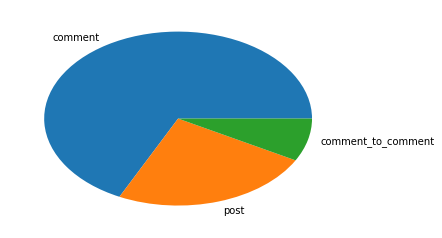

In [126]:
plt.pie(df_pred.label.value_counts(), labels = df_pred.label.value_counts().index)

plt.show()
# это распределение истинных меток, такое же, как и в полном датасете

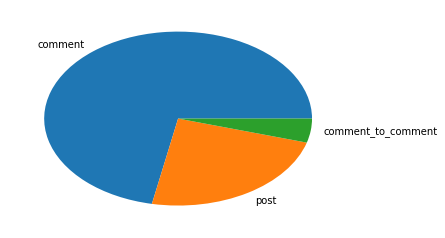

In [127]:
plt.pie(df_pred.label_pred.value_counts(), labels = df_pred.label_pred.value_counts().index)

plt.show()
# а это распределение предсказанных меток: количество комментов увеличено за счет всего остального

In [128]:
# Сделаю датасет из неправильно предсказанных классов
df_pred_wrong = df_pred[df_pred['label'] != df_pred['label_pred']]
df_pred_wrong

,id,text,label,label_pred,likes,len_char,punct,punct_count,punct%,tokens,tokens_count,tokens%,smiles,smiles_count,smiles%,numbers_count,numbers%,latin_count,latin%
31205,39869,орущих баб слушать не бросим,post,comment,27,28,NaN,0,0.000000,"['орущих', 'баб', 'слушать', 'не', 'бросим']",5,0.178571,NaN,0,0.000000,0,0.000000,0,0.000000
21994,51060,"Реально почему колдплей не приезжают, в чем пр...",comment,comment_to_comment,0,109,",,()",4,0.036697,"['Реально', 'почему', 'колдплей', 'не', 'приез...",22,0.201835,NaN,0,0.000000,0,0.000000,0,0.000000
7812,67911,"[id5153501|Sasha], ну и че ещё скажешь\r\r\nза...",comment_to_comment,comment,0,107,"[|],,",5,0.046729,"['[', 'id5153501|Sasha', ']', ',', 'ну', 'и', ...",20,0.186916,NaN,0,0.000000,7,0.065421,7,0.065421
40090,29313,"[id355821001|Suguru], земля тебе пухом братиш",comment,comment_to_comment,0,45,"[|],",4,0.088889,"['[', 'id355821001|Suguru', ']', ',', 'земля',...",8,0.177778,NaN,0,0.000000,9,0.200000,8,0.177778
23355,49385,"[id5416774|Александр], в канистре скорее всего...",comment,comment_to_comment,0,54,"[|],",4,0.074074,"['[', 'id5416774|Александр', ']', ',', 'в', 'к...",9,0.166667,NaN,0,0.000000,7,0.129630,2,0.037037
6882,68922,"Да ладно, нормально к вам сейчас ездят. Иной р...",comment_to_comment,comment,4,86,",.,—.",5,0.058140,"['Да', 'ладно', ',', 'нормально', 'к', 'вам', ...",22,0.255814,NaN,0,0.000000,0,0.000000,0,0.000000
16139,57955,"[id281726539|Станислава], найди себе сначала К...",comment_to_comment,comment,5,129,"[|],,,""""",8,0.062016,"['[', 'id281726539|Станислава', ']', ',', 'най...",27,0.209302,NaN,0,0.000000,9,0.069767,2,0.015504
8944,66426,пилоты заебись в отличие от пиццы с ананасами,comment_to_comment,comment,4,45,NaN,0,0.000000,"['пилоты', 'заебись', 'в', 'отличие', 'от', 'п...",8,0.177778,NaN,0,0.000000,0,0.000000,0,0.000000
2728,73667,"[id150749557|Юлия], я маме расскажу что меня м...",comment_to_comment,comment,9,58,"[|],",4,0.068966,"['[', 'id150749557|Юлия', ']', ',', 'я', 'маме...",11,0.189655,NaN,0,0.000000,9,0.155172,2,0.034483
6136,69615,"[id25373169|Кирилл], в Уфе тоже охранники гоня...",comment_to_comment,comment,3,147,"[|],..",6,0.040816,"['[', 'id25373169|Кирилл', ']', ',', 'в', 'Уфе...",28,0.190476,NaN,0,0.000000,8,0.054422,2,0.013605


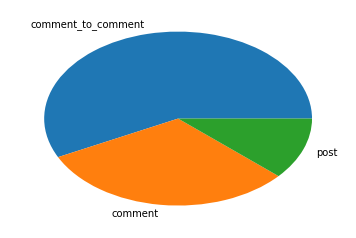

In [129]:
plt.pie(df_pred_wrong.label.value_counts(), labels = df_pred_wrong.label.value_counts().index)

plt.show()
# это распределение истинных меток, которые были неправильно предсказаны - больше всего пострадали комменты второго уровня

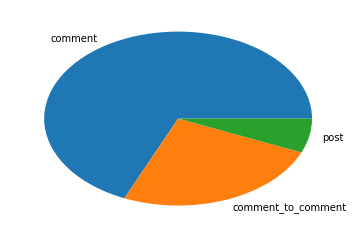

In [130]:
plt.pie(df_pred_wrong.label_pred.value_counts(), labels = df_pred_wrong.label_pred.value_counts().index)

plt.show()
#так распределяются неправильно предсказанные метки:
# бальшая часть из них - предсказанные комменты, которые на самом деле были постами или комментами второго уровня

Посмотрю, есть ли что-то особенное у всех этих неправильно распознанных классов

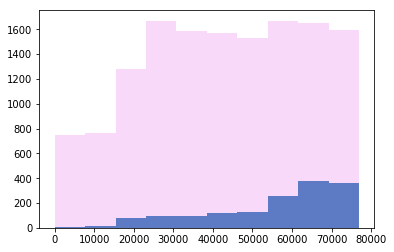

In [272]:
plt.hist(df_pred_wrong.id)
plt.hist(df_pred.id, color = 'violet', alpha = 0.3, label = 'all predicted')
plt.show()

Среди неправильно определенных текстов сильно больше свежих текстов (у айди текстов сквозная нумерация, которая проходит через комменты тоже, у самого первого поста, когда группу только создали, id=1 ), но это выходит из особенностей датасета. В группе первые пару лет были закрыты комменты, соответственно, тексты с маленькими айдишниками - это только посты. А комменты к комментам вообще недавно стали часто появляться, когда в группе увеличилось число подписчиков.

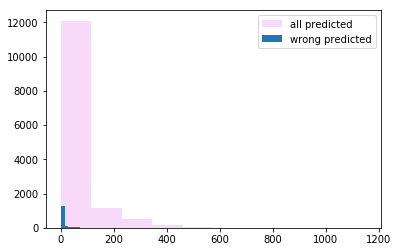

In [153]:
plt.hist(df_pred.likes, alpha = 0.3, color = 'violet', label = 'all predicted')
plt.hist(df_pred_wrong.likes, alpha = 1, label = 'wrong predicted')
plt.legend(loc = 'upper right')
plt.show()

Из графика видно, что тексты, у которых мало лайков, сложнее правильно предсказать

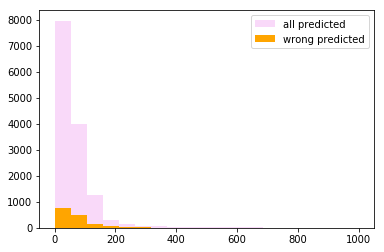

In [148]:
bins= np.linspace(0,1000, 20)
plt.hist(df_pred.len_char, bins, alpha = 0.3, color = 'violet', label = 'all predicted')
plt.hist(df_pred_wrong.len_char, bins, alpha = 1, color = 'orange', label = 'wrong predicted')
plt.legend(loc = 'upper right')
plt.show()

признак количества элементов в тексте, кажется, влияет не сильно, так как оба графика пропорциональны

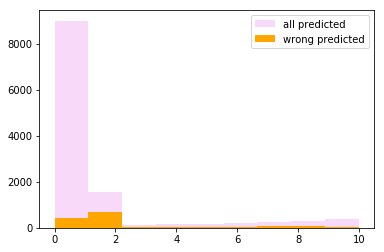

In [166]:
bins= np.linspace(0,10, 10)
plt.hist(df_pred['latin_count'], bins, alpha = 0.3, color = 'violet', label = 'all predicted')
plt.hist(df_pred_wrong['latin_count'], bins, alpha = 1, color = 'orange', label = 'wrong predicted')
plt.legend(loc = 'upper right')
plt.show()

здесь видно, что среди неправильно предсказанных текстов выделяются те, в которых 2 латинские буквы. Это как раз комменты второго уровня, которые начинаются с [id5416774|Александр] и проч. Жаль, что ни один классификатор не сообразил про такой важный признак. Я думаю, это из-за того, что датасет был маленький.

##### Кластеризация 

Сейчас я попробую кластеризовать датасет, интересно, на какие кластеры он разобьется. Я не думаю, что кластеры совпадут с разбивкой на посты\комменты\комменты к комментам, но любопытно посмотреть, что мы можем увидеть здесь с помощью кластеризации

In [169]:
model1 = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, n_jobs=-1, random_state=44)
model1.fit(a)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=44, tol=0.0001, verbose=0)

In [171]:
model2 = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, n_jobs=-1, random_state=88)
model2.fit(a)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=88, tol=0.0001, verbose=0)

In [172]:
labels1 = model1.labels_ 
labels2 = model2.labels_ 

In [176]:
adjusted_rand_score(labels1, labels2)

0.9988901218802845

У классификатора нет сомнений, оба раза он поделил датасет одинаково. Интересно, как.


Как и было ясно до, кластеризация к разделению на посты\комменты\комменты к комментам отношения не имеет:

In [177]:
adjusted_rand_score(labels1, df_features.label)

0.38959138562920576

In [182]:
# добавим в датасет колоночку с кластерами
df_features['clasters'] = labels1
new_ordered_names = ['id', 'text', 'label','clasters', 'likes', 'len_char', 'punct', 'punct_count',
       'punct%', 'tokens', 'tokens_count', 'tokens%', 'smiles', 'smiles_count',
       'smiles%', 'numbers_count', 'numbers%', 'latin_count', 'latin%']
df_features = df_features[new_ordered_names]
df_features

,id,text,label,clasters,likes,len_char,punct,punct_count,punct%,tokens,tokens_count,tokens%,smiles,smiles_count,smiles%,numbers_count,numbers%,latin_count,latin%
0,76000,#конкурс@the4gkz \r\r\nДля вашего удобства соб...,post,1,17,503,"#@.:•|-.—:./:./•|-.—/:./:://./|://./•|.—:./:.,!",47,0.093439,"['#', 'конкурс', '@', 'the4gkz', 'Для', 'вашег...",81,0.161034,NaN,0,0.000000,23,0.045726,116,0.230616
1,76914,Уже сегодня ночью (по МСК) начнётся один из са...,post,1,34,669,"()—.—()!..,!(),—(,).:://..//",28,0.041854,"['Уже', 'сегодня', 'ночью', '(', 'по', 'МСК', ...",111,0.165919,NaN,0,0.000000,0,0.000000,49,0.073244
2,76917,"Ого, Нина Кравиц в лайн-апе😲",comment,0,0,28,",-",2,0.071429,"['Ого', ',', 'Нина', 'Кравиц', 'в', 'лайн-апе😲']",6,0.214286,😲,1,0.035714,0,0.000000,0,0.000000
3,76920,"[id17823823|Анастасия], с новым крутым шоу от ...",comment_to_comment,0,0,56,"[|],",4,0.071429,"['[', 'id17823823|Анастасия', ']', ',', 'с', '...",11,0.196429,NaN,0,0.000000,8,0.142857,2,0.035714
4,76922,Скину расписание на сегодня сюда. Время москов...,comment,1,0,687,..:......&....:..........:......&.....,38,0.055313,"['Скину', 'расписание', 'на', 'сегодня', 'сюда...",112,0.163028,NaN,0,0.000000,127,0.184862,332,0.483261
5,76933,"[id18399319|Anastasia], неправда, в Москве вре...",comment_to_comment,0,0,85,"[|],,,",6,0.070588,"['[', 'id18399319|Anastasia', ']', ',', 'непра...",17,0.200000,NaN,0,0.000000,8,0.094118,11,0.129412
6,76929,"Трансляция, конечно, моё почтение. Классно выг...",comment,0,1,66,",,..",4,0.060606,"['Трансляция', ',', 'конечно', ',', 'моё', 'по...",12,0.181818,NaN,0,0.000000,0,0.000000,0,0.000000
7,76930,"Моё увожение Блэкпинк, которые даже с живыми и...",comment,0,1,83,",.",2,0.024096,"['Моё', 'увожение', 'Блэкпинк', ',', 'которые'...",14,0.168675,🤘,1,0.012048,0,0.000000,0,0.000000
8,76934,"Часть пропустила, конец сета у SG Lewis был кл...",comment,0,0,307,",.-,,.-,-",9,0.029316,"['Часть', 'пропустила', ',', 'конец', 'сета', ...",56,0.182410,🙀🔥,2,0.006515,4,0.013029,40,0.130293
9,76935,"сейчас посмотрела лайв Rufus Du Sol, очень бод...",comment,0,0,134,",.,",3,0.022388,"['сейчас', 'посмотрела', 'лайв', 'Rufus', 'Du'...",21,0.156716,NaN,0,0.000000,0,0.000000,10,0.074627


Вот отсюда https://stackoverflow.com/questions/45234336/value-at-kmeans-cluster-centers-in-sklearn-kmeans
    я взяла, как посмотреть на центроиды.

In [190]:
from sklearn.metrics import pairwise_distances_argmin_min
closest, _ = pairwise_distances_argmin_min(model1.cluster_centers_, a)

In [191]:
closest, _

(array([24352, 53306, 41292], dtype=int64),
 array([  3.75825455,   8.8176691 , 110.83520551]))

In [201]:
# Вот самые яркие представители всех трех классов
ultimate_features = df_features.loc[[24352, 53306, 41292]]
ultimate_features

,id,text,label,clasters,likes,len_char,punct,punct_count,punct%,tokens,tokens_count,tokens%,smiles,smiles_count,smiles%,numbers_count,numbers%,latin_count,latin%
24352,48191,"Фон вводит в заблуждение, захотелось на Muse ш...",comment,0,13,53,",",1,0.018868,"['Фон', 'вводит', 'в', 'заблуждение', ',', 'за...",10,0.188679,NaN,0,0.0,0,0.000000,4,0.075472
53306,7380,стоит ли приходить на ласточку с утра чтобы за...,post,1,215,148,NaN,0,0.000000,"['стоит', 'ли', 'приходить', 'на', 'ласточку',...",24,0.162162,NaN,0,0.0,4,0.027027,5,0.033784
41292,27958,#bestof2017@the4gkz\r\r\n\r\r\nEd Sheeran Divi...,post,2,97,2677,"#@-,,.,(),.,?«,».,,.-,,-.,:))-,.,,.,.,.,.,.--,...",94,0.035114,"['#', 'bestof2017', '@', 'the4gkz', 'Ed', 'She...",496,0.185282,NaN,0,0.0,10,0.003736,249,0.093015


Я немножко поигралась с графиками, чтобы точнее понять, по какому принципу устроены кластеры

In [209]:
feature_zero = df_features[df_features.clasters == 0]
feature_one = df_features[df_features.clasters == 1]

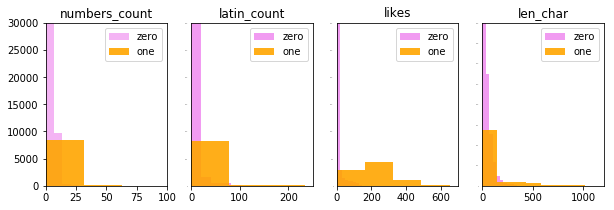

In [269]:
bins= np.linspace(0,20, 10)
plt.figure(1, figsize=(10, 3))
plt.subplot(141)
plt.hist(feature_zero['numbers_count'],  alpha = 0.6, color = 'violet', label = 'zero')
plt.hist(feature_one['numbers_count'],  alpha = 0.9, color = 'orange', label = 'one')
plt.axis([0, 100, 0, 30000])
plt.title('numbers_count')
plt.legend(loc = 'upper right')


plt.subplot(142)
plt.hist(feature_zero['latin_count'],  alpha = 0.8, color = 'violet', label = 'zero')
plt.hist(feature_one['latin_count'],  alpha = 0.9, color = 'orange', label = 'one')
plt.axis([0, 250, 0, 30000])
plt.title('latin_count')
plt.tick_params(axis='y', labelsize=0, length = 0)
plt.legend(loc = 'upper right')


plt.subplot(143)
plt.hist(feature_zero['likes'],  alpha = 0.8, color = 'violet', label = 'zero')
plt.hist(feature_one['likes'],  alpha = 0.9, color = 'orange', label = 'one')
plt.axis([0, 700, 0, 30000])
plt.title('likes')
plt.tick_params(axis='y', labelsize=0, length = 0)
plt.legend(loc = 'upper right')


plt.subplot(144)
plt.hist(feature_zero['len_char'],  alpha = 0.8, color = 'violet', label = 'zero')
plt.hist(feature_one['len_char'],  alpha = 0.9, color = 'orange', label = 'one')
plt.axis([0, 1200, 0, 20000])
plt.title('len_char')
plt.tick_params(axis='y', labelsize=0, length = 0)


plt.legend(loc = 'upper right')
plt.show()

В кластер с меткой 2 попали в основном самые большие по объему тексты, со множеством знаков препинания и цифр, то есть строки датасета с самыми большими числами в признаках. Таких текстов мало, меньше сотни. 

Кластеры с метками 0 и 1 не так очевидно отделяемы друг от друга, поэтому я сделала для них графики. В кластер с меткой "0" вошли векторы, где почти всё по нулям и близко к нулю в векторах. Таких текстов большинство.

А класс 1 - это класс, средний между "0" и "2": в нем вектора в сумме (или как оно там считается) дают чуть больше, чем в в классе "0", но не так много, как в классе "2".

То есть метод кластеризации оказался на таких признаках не очень полезным, потому что эти данные можно легко увидеть и без машинного обучения - это просто статистика

#### Таким образом:
    - на количественных признаках лучше всего сработало Дерево решений,
    - классы, которые мало представлены, плохо распознаются даже по очевидным признакам,
    - нормализация признаков не повлияла на результаты,
    - самые важные признаки: лайки, числительные и латиница,
    - кластеризация произошла по признаку суммы элементов векторов